In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import tqdm as tqdm
import lightning.pytorch as pl
from pytorch_lightning.loggers import WandbLogger
import wandb
from torchmetrics.image.fid import FrechetInceptionDistance


class ResidualStack(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        layers = []
        for i in range(num_residual_layers):
            layers.append(
                nn.Sequential(
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=num_hiddens,
                        out_channels=num_residual_hiddens,
                        kernel_size=3,
                        padding=1,
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=num_residual_hiddens,
                        out_channels=num_hiddens,
                        kernel_size=1,
                    ),
                )
            )

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        h = x
        for layer in self.layers:
            h = h + layer(h)

        # ResNet V1-style.
        return torch.relu(h)


class Encoder(nn.Module):
    def __init__(
        self,
        in_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
    ):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        # The last ReLU from the Sonnet example is omitted because ResidualStack starts
        # off with a ReLU.
        conv = nn.Sequential()
        for downsampling_layer in range(num_downsampling_layers):
            if downsampling_layer == 0:
                out_channels = num_hiddens // 2
            elif downsampling_layer == 1:
                (in_channels, out_channels) = (num_hiddens // 2, num_hiddens)

            else:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            conv.add_module(
                f"down{downsampling_layer}",
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                ),
            )
            conv.add_module(f"relu{downsampling_layer}", nn.ReLU())

        conv.add_module(
            "final_conv",
            nn.Conv2d(
                in_channels=num_hiddens,
                out_channels=num_hiddens,
                kernel_size=3,
                padding=1,
            ),
        )
        self.conv = conv
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )

    def forward(self, x):
        h = self.conv(x)
        return self.residual_stack(h)


class Decoder(nn.Module):
    def __init__(
        self,
        embedding_dim,
        num_hiddens,
        num_upsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
        out,
    ):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        self.conv = nn.Conv2d(
            in_channels=embedding_dim,
            out_channels=num_hiddens,
            kernel_size=3,
            padding=1,
        )
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )
        upconv = nn.Sequential()
        for upsampling_layer in range(num_upsampling_layers):
            if upsampling_layer < num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            elif upsampling_layer == num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens, num_hiddens // 2)

            elif upsampling_layer > num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens // 2, out)
            else:
                raise ValueError(
                    f"Invalid upsampling layer: {upsampling_layer}. In Encoder."
                )

            upconv.add_module(
                f"up{upsampling_layer}",
                nn.ConvTranspose2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                ),
            )
            if upsampling_layer < num_upsampling_layers - 1:
                upconv.add_module(f"relu{upsampling_layer}", nn.ReLU())

        self.upconv = upconv

    def forward(self, x):
        h = self.conv(x)
        h = self.residual_stack(h)
        x_recon = self.upconv(h)
        return F.sigmoid(x_recon)


class SonnetExponentialMovingAverage(nn.Module):
    # See: https://github.com/deepmind/sonnet/blob/5cbfdc356962d9b6198d5b63f0826a80acfdf35b/sonnet/src/moving_averages.py#L25.
    # They do *not* use the exponential moving average updates described in Appendix A.1
    # of "Neural Discrete Representation Learning".
    def __init__(self, decay, shape):
        super().__init__()
        self.decay = decay
        self.counter = 0
        self.register_buffer("hidden", torch.zeros(*shape))
        self.register_buffer("average", torch.zeros(*shape))

    def update(self, value):
        self.counter += 1
        with torch.no_grad():
            self.hidden -= (self.hidden - value) * (1 - self.decay)
            self.average = self.hidden / (1 - self.decay**self.counter)

    def __call__(self, value):
        self.update(value)
        return self.average


class VectorQuantizer(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, use_ema, decay, epsilon):
        super().__init__()
        # See Section 3 of "Neural Discrete Representation Learning" and:
        # https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L142.

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.use_ema = use_ema
        # Weight for the exponential moving average.
        self.decay = decay
        # Small constant to avoid numerical instability in embedding updates.
        self.epsilon = epsilon

        # Dictionary embeddings.
        limit = 3**0.5
        e_i_ts = torch.FloatTensor(embedding_dim, num_embeddings).uniform_(
            -limit, limit
        )
        if use_ema:
            self.register_buffer("e_i_ts", e_i_ts)
        else:
            self.register_parameter("e_i_ts", nn.Parameter(e_i_ts))

        # Exponential moving average of the cluster counts.
        self.N_i_ts = SonnetExponentialMovingAverage(decay, (num_embeddings,))
        # Exponential moving average of the embeddings.
        self.m_i_ts = SonnetExponentialMovingAverage(decay, e_i_ts.shape)

    def forward(self, x):
        flat_x = x.permute(0, 2, 3, 1).reshape(-1, self.embedding_dim)
        distances = (
            (flat_x**2).sum(1, keepdim=True)
            - 2 * flat_x @ self.e_i_ts
            + (self.e_i_ts**2).sum(0, keepdim=True)
        )
        encoding_indices = distances.argmin(1)
        quantized_x = F.embedding(
            encoding_indices.view(x.shape[0], *x.shape[2:]), self.e_i_ts.transpose(0, 1)
        ).permute(0, 3, 1, 2)

        # See second term of Equation (3).
        if not self.use_ema:
            dictionary_loss = ((x.detach() - quantized_x) ** 2).mean()
        else:
            dictionary_loss = None

        # See third term of Equation (3).
        commitment_loss = ((x - quantized_x.detach()) ** 2).mean()
        # Straight-through gradient. See Section 3.2.
        quantized_x = x + (quantized_x - x).detach()

        if self.use_ema and self.training:
            with torch.no_grad():
                # See Appendix A.1 of "Neural Discrete Representation Learning".

                # Cluster counts.
                encoding_one_hots = F.one_hot(
                    encoding_indices, self.num_embeddings
                ).type(flat_x.dtype)
                n_i_ts = encoding_one_hots.sum(0)
                # Updated exponential moving average of the cluster counts.
                # See Equation (6).
                self.N_i_ts(n_i_ts)

                # Exponential moving average of the embeddings. See Equation (7).
                embed_sums = flat_x.transpose(0, 1) @ encoding_one_hots
                self.m_i_ts(embed_sums)

                # This is kind of weird.
                # Compare: https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L270
                # and Equation (8).
                N_i_ts_sum = self.N_i_ts.average.sum()
                N_i_ts_stable = (
                    (self.N_i_ts.average + self.epsilon)
                    / (N_i_ts_sum + self.num_embeddings * self.epsilon)
                    * N_i_ts_sum
                )
                self.e_i_ts = self.m_i_ts.average / N_i_ts_stable.unsqueeze(0)

        return (
            quantized_x,
            dictionary_loss,
            commitment_loss,
            encoding_indices.view(x.shape[0], -1),
        )


class VQVAE(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
        embedding_dim,
        num_embeddings,
        use_ema,
        decay,
        epsilon,
    ):
        super().__init__()
        self.encoder = Encoder(
            in_channels,
            num_hiddens,
            num_downsampling_layers,
            num_residual_layers,
            num_residual_hiddens,
        )
        self.pre_vq_conv = nn.Conv2d(
            in_channels=num_hiddens, out_channels=embedding_dim, kernel_size=1
        )
        self.vq = VectorQuantizer(
            embedding_dim, num_embeddings, use_ema, decay, epsilon
        )
        self.decoder = Decoder(
            embedding_dim,
            num_hiddens,
            num_downsampling_layers,
            num_residual_layers,
            num_residual_hiddens,
            out_channels,
        )

    def quantize(self, x):
        z = self.pre_vq_conv(self.encoder(x))
        (z_quantized, dictionary_loss, commitment_loss, encoding_indices) = self.vq(z)
        return (z_quantized, dictionary_loss, commitment_loss, encoding_indices)

    def forward(self, x):
        (z_quantized, dictionary_loss, commitment_loss, encoding_indices) = (
            self.quantize(x)
        )
        x_recon = self.decoder(z_quantized)
        return {
            "dictionary_loss": dictionary_loss,
            "commitment_loss": commitment_loss,
            "x_recon": x_recon,
            "encoding_indices": encoding_indices,
        }


class VQVAE_Trainer(pl.LightningModule):
    def __init__(
        self,
        sample_size=128,
        in_channels=3,
        out_channels=3,
        num_hiddens=64,
        num_downsampling_layers=2,
        num_residual_layers=4,
        num_residual_hiddens=128,
        embedding_dim=64,  # 32, 64, 128, 256
        num_embeddings=2048,  # 256, 512, 1024, 2048
        use_ema=True,
        decay=0.99,
        epsilon=1e-5,
        beta=0.25,
        lr=2e-4,
        weight_decay=0.0,
        fid_features=2048,
        batch_size=64,  # 128
        dataset="celeba_hq",
    ):
        super(VQVAE_Trainer, self).__init__()
        self.model = VQVAE(
            in_channels=in_channels,
            out_channels=out_channels,
            num_hiddens=num_hiddens,
            num_downsampling_layers=num_downsampling_layers,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens,
            embedding_dim=embedding_dim,
            num_embeddings=num_embeddings,
            use_ema=use_ema,
            decay=decay,
            epsilon=epsilon,
        )

        self.beta = beta
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, _ = batch

        out = self.model(x)
        recon_error = F.mse_loss(out["x_recon"], x)

        loss = recon_error + self.beta * out["commitment_loss"]

        if out["dictionary_loss"] is not None:
            loss += out["dictionary_loss"]
            self.log("train_dictionary_loss", out["dictionary_loss"])

        self.log("train_loss", loss)
        self.log("train_recon_error", recon_error)
        self.log("train_commitment_loss", out["commitment_loss"])

        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch

        out = self.model(x)

        recon_error = F.mse_loss(out["x_recon"], x)

        loss = recon_error + self.beta * out["commitment_loss"]

        if out["dictionary_loss"] is not None:
            loss += out["dictionary_loss"]
            self.log("val_dictionary_loss", out["dictionary_loss"])

        self.log("val_loss", loss)
        self.log("val_recon_error", recon_error)
        self.log("val_commitment_loss", out["commitment_loss"])

        if batch_idx == 0:
            if self.global_step == 0 and batch_idx == 0:
                self.logger.experiment.log(
                    {
                        "original": wandb.Image(
                            torchvision.utils.make_grid(x[:64], nrow=8),
                            caption="Real Image",
                        )
                    }
                )

            self.logger.experiment.log(
                {
                    "reconstructed": wandb.Image(
                        torchvision.utils.make_grid(out["x_recon"][:64], nrow=8),
                        caption=f"Step {self.global_step}",
                    )
                }
            )

    def on_test_start(self):
        self.fid = FrechetInceptionDistance(self.hparams.fid_features).cpu()

    def test_step(self, batch, batch_idx):
        x, _ = batch

        out = self.model(x)

        # Resize to 299x299
        x = F.interpolate(x, size=299)
        x_hat = F.interpolate(out["x_recon"], size=299)

        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
            x_hat = x_hat.repeat(1, 3, 1, 1)

        # Convert to uint8
        x = (x * 255).to(torch.uint8).cpu()
        x_hat = (x_hat * 255).to(torch.uint8).cpu()

        # Compute FID
        self.fid.update(x, real=True)
        self.fid.update(x_hat, real=False)

        fid_score = self.fid.compute()
        self.log("fid_score", fid_score)

    def configure_optimizers(self):
        return optim.Adam(
            self.model.parameters(),
            lr=self.hparams.lr,
            amsgrad=True,
            weight_decay=self.hparams.weight_decay,
        )

    def train_dataloader(self):
        if self.hparams.dataset == "mnist":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    (
                        torchvision.transforms.Grayscale()
                        if self.hparams.in_channels == 1
                        else torchvision.transforms.Lambda(lambda x: x)
                    ),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.MNIST(
                root="data/mnist", train=True, transform=transform, download=True
            )

        elif self.hparams.dataset == "cifar10":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.CIFAR10(
                root="data/cifar10", train=True, transform=transform, download=True
            )

        elif self.hparams.dataset == "celeba_hq":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.ImageFolder(
                "data/celeba_hq/train", transform=transform
            )

        else:
            raise ValueError(f"Unknown dataset: {self.hparams.dataset}")

        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.hparams.batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            persistent_workers=True,
        )

    def val_dataloader(self):
        if self.hparams.dataset == "mnist":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.MNIST(
                root="data/mnist", train=False, transform=transform, download=True
            )

        elif self.hparams.dataset == "cifar10":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.CIFAR10(
                root="data/cifar10", train=False, transform=transform, download=True
            )

        elif self.hparams.dataset == "celeba_hq":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.ImageFolder(
                "data/celeba_hq/val", transform=transform
            )

        else:
            raise ValueError(f"Unknown dataset: {self.hparams.dataset}")

        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.hparams.batch_size,
            num_workers=4,
            pin_memory=True,
            persistent_workers=True,
        )

    def test_dataloader(self):
        if self.hparams.dataset == "mnist":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.MNIST(
                root="data/mnist", train=False, transform=transform, download=True
            )
            # Return first 1/4
            dataset = torch.utils.data.Subset(dataset, range(len(dataset) // 16))

        elif self.hparams.dataset == "cifar10":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.CIFAR10(
                root="data/cifar10", train=False, transform=transform, download=True
            )
            # Return first 1/4
            dataset = torch.utils.data.Subset(dataset, range(len(dataset) // 16))

        elif self.hparams.dataset == "celeba_hq":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.ImageFolder(
                "data/celeba_hq/val", transform=transform
            )
            # Return first 1/4
            dataset = torch.utils.data.Subset(dataset, range(len(dataset) // 4))

        else:
            raise ValueError(f"Unknown dataset: {self.hparams.dataset}")

        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.hparams.batch_size,
            num_workers=4,
            pin_memory=True,
            persistent_workers=True,
        )

# load from checkpoint
vqvae = VQVAE_Trainer.load_from_checkpoint("archive/misc/vq-vae/vqvae/logs/vq-vae/mnist-32/checkpoints/epoch=10-step=10000.ckpt")
vqvae = vqvae.model.to("mps")

In [2]:
device = "mps"


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from ema_pytorch import EMA
import tqdm.notebook as tqdm
from torchmetrics.image.fid import FrechetInceptionDistance
import diffusers
import matplotlib.pyplot as plt


In [4]:
# train_dataset = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Resize((32,32))
# ]))
# test_dataset = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Resize((32,32))
# ]))

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True, pin_memory=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, persistent_workers=True, pin_memory=True)


In [5]:
# x, y = next(iter(test_loader))

# grid = torchvision.utils.make_grid(x, nrow=16)

# plt.figure(figsize=(20,20))
# plt.imshow(grid.permute(1, 2, 0))
# plt.axis("off")
# plt.show()


In [11]:
model = diffusers.UNet2DModel(
    sample_size=(8, 8),
    in_channels=4,
    out_channels=4,
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
    ),  # "DownBlock2D", "CrossAttnDownBlock2D",
    up_block_types=(
        "UpBlock2D",
        "UpBlock2D",
    ),  # "UpBlock2D", "CrossAttnUpBlock2D",
    block_out_channels=(32, 64),
    layers_per_block=2,
    num_class_embeds=10,
).to(device)

num_train_steps = 0
print(f"Model has {model.num_parameters():,}")

Model has 920,900


In [12]:
scheduler = diffusers.DDIMScheduler(
    num_train_timesteps=4000,
    rescale_betas_zero_snr=True,
    beta_schedule="squaredcos_cap_v2"
)


In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=4e-5, amsgrad=True)
criterion = torch.nn.MSELoss()


In [9]:
train_loader = torch.utils.data.DataLoader(
    torch.load("archive/misc/vq-vae/z_embed/train_z_embed.pt"),
    batch_size=64,
    shuffle=True,
    num_workers=4,
    persistent_workers=True,
    pin_memory=True,
)

test_loader = torch.utils.data.DataLoader(
    torch.load("archive/misc/vq-vae/z_embed/val_z_embed.pt"),
    batch_size=128,
    shuffle=False,
    num_workers=4,
    persistent_workers=True,
    pin_memory=True,
)

In [10]:
@torch.no_grad()
def generate(batch_size, eta, num_inference_steps):
    if batch_size % 10 != 0:
        raise ValueError("Batch size must be divisible by 10")

    image = torch.randn(batch_size, 4, 8, 8, device=device)
    classes = torch.arange(10, device=device).repeat(batch_size // 10)
    # set step values
    scheduler.set_timesteps(num_inference_steps)

    for t in range(num_inference_steps):
        # 1. predict noise model_output
        model_output = model.forward(image, timestep=t, class_labels=classes).sample


        # 2. predict previous mean of image x_t-1 and add variance depending on eta
        # eta corresponds to η in paper and should be between [0, 1]
        # do x_t -> x_t-1
        image = scheduler.step(
            model_output,
            t,
            image,
            eta=eta,
        ).prev_sample

    # imgs = (image / 2 + 0.5).clamp(0, 1).cpu()

    imgs = vqvae.decoder(image).cpu()

    plt.figure(figsize=(20, 5))

    for i in range(batch_size):
        plt.subplot(batch_size//10, 10, i + 1)
        plt.imshow(imgs[i].squeeze(), cmap="gray")
        plt.title(f"Number {classes[i]}")
        plt.axis("off")
        
    plt.suptitle(f"Generated Images after {num_train_steps:,} steps")
    plt.font_size = 28
    plt.tight_layout()
    plt.axis("off")
    plt.show()

generate(10, 1, 50)


TypeError: UNet2DConditionModel.forward() missing 1 required positional argument: 'encoder_hidden_states'

In [ ]:
@torch.no_grad()
def test():
    losses = []
    for x,y in tqdm.tqdm(test_loader, desc="Testing"):
        x, y = x.to(device), y.to(device)
        t = torch.randint(0, scheduler.config.num_train_timesteps, (x.size(0),), device=device).long()
        noise = torch.randn_like(x, device=device)

        noisy_x = scheduler.add_noise(x, noise, t)

        pred = model.forward(sample=noisy_x, timestep=t, class_labels=y).sample

        loss = criterion(pred, noise)

        losses.append(loss.item())

    return sum(losses) / len(losses)

In [ ]:
ema = EMA(model, beta=0.999, update_after_step=100, update_every=10)

In [ ]:
val_loss = test()

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
pbar = tqdm.trange(10, desc="Epochs", unit="epochs")

for epoch in pbar:
    for x, y in tqdm.tqdm(train_loader, desc="Batches", unit="batches", leave=True):
        x = x.to(device)
        y = y.to(device)
        
        t = torch.randint(0, scheduler.config.num_train_timesteps, (x.size(0),), device=device, dtype=torch.long)
        noise = torch.randn_like(x, device=device)

        noisy_x = scheduler.add_noise(x, noise, t)

        pred = model.forward(sample=noisy_x, timestep=t, class_labels=y).sample

        loss = criterion(pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_train_steps += 1

        ema.update()

        if num_train_steps % 500 == 0:
            # generate(10, 1, 50)
            val_loss = test()

        pbar.set_postfix_str(f"Loss: {loss:.4f}, Val Loss: {val_loss:.4f}")
        pbar.set_description(f"Epochs {num_train_steps:,}")

Epochs:   0%|          | 0/10 [00:00<?, ?epochs/s]

Batches:   0%|          | 0/938 [00:00<?, ?batches/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?batches/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?batches/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?batches/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?batches/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?batches/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?batches/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?batches/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?batches/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?batches/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

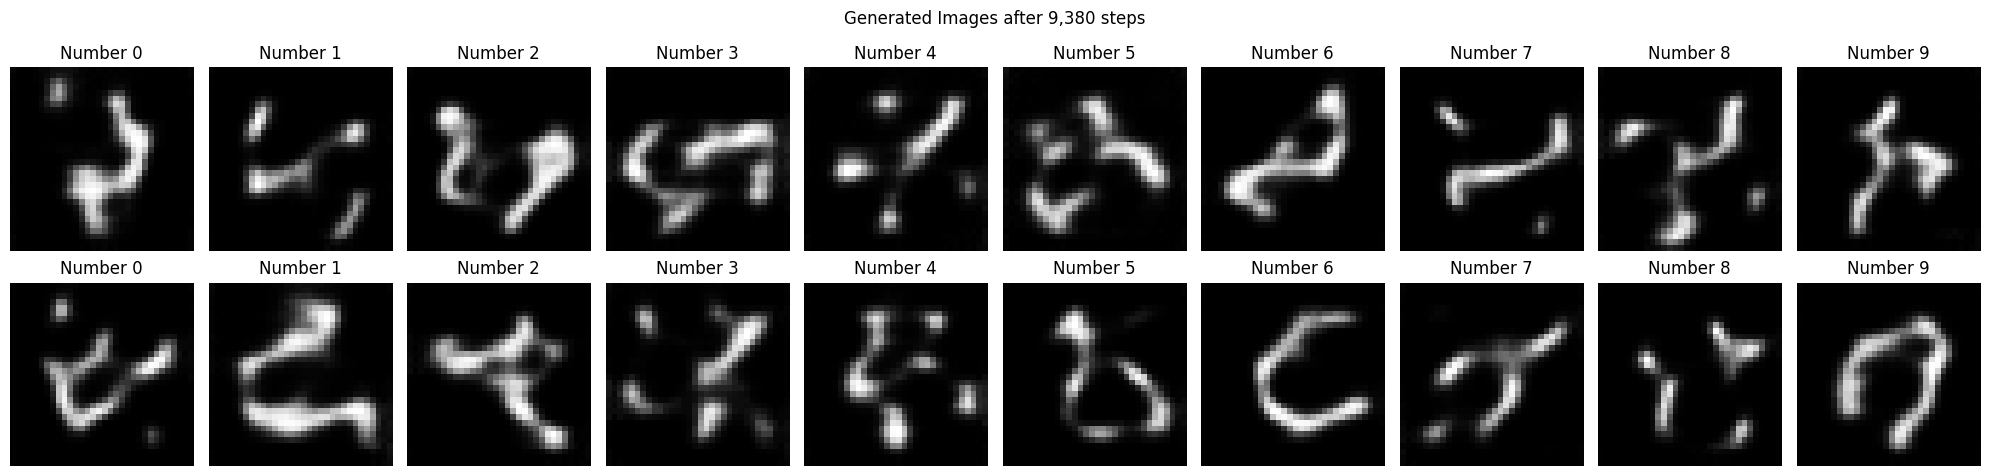

In [15]:
generate(20, 1, 50)

In [ ]:
#Validation
def validate():
    pbar = tqdm.tqdm(test_loader, desc="Validation", unit="batch", leave=False)
    for x, _ in pbar:
        x = x.to(device)
        t = torch.randint(0, 1000, (x.size(0),), device=device).long()
        noise = torch.randn_like(x, device=device)

        noisy_x = scheduler.add_noise(x, noise, t)

        pred = model.forward(noisy_x, t).sample

        loss = criterion(pred, noise)

        pbar.set_postfix_str(f"Total Steps: {num_train_steps:,}, Loss: {loss:.4f}")

    generate(16, 0, 50)

validate()


In [ ]:
torch.save(model.state_dict(), "projects/paper-implementations/image-generation/7-ddpm/models/mnist1.pth")


In [ ]:
with torch.no_grad():
    fid = FrechetInceptionDistance(feature=2048)
    pipeline = diffusers.DDIMPipeline(model, scheduler).to(device)
    pbar = tqdm.tqdm(test_loader, desc="FID", unit="batch", leave=False)
    
    fids = []
    for i in pbar:
        imgs = pipeline(100, eta=1, num_inference_steps=50, output_type="np").images
        imgs = torch.as_tensor(imgs).permute(0, 3, 1, 2)
        
        x, y = next(iter(test_loader))
        x = x.to(device)
        
        imgs = F.interpolate(imgs, size=(299, 299), mode="bilinear", align_corners=False)
        x = F.interpolate(x, size=(299, 299), mode="bilinear", align_corners=False)
        
        # Convert to UINT8
        imgs = (imgs * 255).clamp(0, 255).to(torch.uint8)
        x = (x * 255).clamp(0, 255).to(torch.uint8)
        
        fid.update(imgs, False)
        fid.update(x, True)
        
        fids.append(fid.compute().item())
        
        pbar.set_postfix_str(f"FID: {fids[-1]:.2f}")
